# Set up

In [1]:
import os.path as op
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from glob import glob
import re
import pandas as pd
import operator
import unittest
import sys
import operator
from sklearn.model_selection import *
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot')
%load_ext line_profiler
%matplotlib inline

In [2]:
# Load data
print("Loading dataset")

filenames_neg = sorted(glob(op.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join('.', 'data', 'imdb1', 'pos', '*.txt')))

texts_neg = [open(f).read() for f in filenames_neg]
texts_pos = [open(f).read() for f in filenames_pos]
texts = texts_neg + texts_pos
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" %len(texts))

Loading dataset
2000 documents


# Implementation of the classifier
## Question 1
Complete the <code>count_words</code> function that will count the number of occurrences of each distinct
word in a list of string and return vocabulary (the python dictionary. The dictionary keys are the
different words and the values are their number of occurences).

In [3]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts

    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """  
    
    wordList = re.subn('\W', ' ', ' '.join(texts).lower())[0].split(' ')
    words = set(wordList)
    vocabulary = dict(zip(words, range(len(words))))
              
    n_features = len(words)
    counts = np.zeros( (len(texts), n_features))
    
    for l, text in enumerate(texts, 0):
        wordList = re.subn('\W', ' ', text.lower())[0].split(' ')
        for word in wordList:
            if(word == ''): continue
            counts[l][vocabulary[word]] = counts[l][vocabulary[word]] + 1   
    return vocabulary, counts

## Question 2
Explain how positive and negative classes have been assigned to movie reviews (see poldata.README.2.0 file)

According to the poldata.README.2.0 file, movie reviews may not have an explicit note. In the case where there is a note, this one can appear to different place of the file and in different forms. In the case of our data we focus only on the most explicit notations, resulting from an ad-hoc set of rules. The classification of a file is thus established from the first note of which one is able to identify.

- With a five-star system (or equivalent digital system), more than 3.5 stars lead to positive reviews, and fewer than 2 stars lead to negative reviews.
- With a four-star system (or equivalent digital system), more than 3 stars lead to positive reviews, and fewer than 1.5 stars lead to negative reviews.
- With a system consisting of letters, B or above leads to a positive critique, and C- or below is considered negative.


## Question 3
Complete the NB class to implement the Naive Bayes classifier.

In [4]:
class NB(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

        
    def fit(self, X, y):
        N = X.shape[0]
        val, counter = np.unique(y, return_counts=True)
        self.class_counter = dict(zip(val, counter))
        nb_word = X.shape[1]
        nb_class = val.shape[0]
        
        self.condprob = dict()
        self.prior = np.zeros(nb_class)
        T = {c:np.sum(X[y==c, :], axis=0) for c in self.class_counter}
        
        for c,Nc in self.class_counter.items():
            self.prior[c] = Nc/N
            self.condprob[c] = (T[c] +1) / ( np.sum(T[c] + 1))

        return self

    def predict(self, X):
        X = np.array(X)
        y = [self.apply(vec) for vec in X]
        return np.array(y)
    
    def apply(self, vector):
        vector = np.array(vector)
        score = dict()
        for c in self.class_counter:
            score[c] = np.log(self.prior[c])
            score[c] += np.log(self.condprob[c][vector >0.0]).sum()
        return max(score.items(), key=operator.itemgetter(1))[0]
    
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [5]:
# Count words in text
vocabulary, X = count_words(texts)

# Try to fit, predict and score
nb = NB()
nb.fit(X[::2], y[::2])
score = nb.score(X[1::2], y[1::2])
score

0.822

## Question 4 
Evaluate the performance of your classifier in cross-validation 5-folds

In [6]:
# Try to fit, predict and score
nb = NB()
my_nb_res = cross_validate(nb, X, y, cv=5)
my_nb_res

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.7490356 , 0.75698948, 0.80385447, 0.78589773, 0.85076666]),
 'score_time': array([0.14162755, 0.13062   , 0.13367033, 0.14165926, 0.1475637 ]),
 'test_score': array([0.8225, 0.8325, 0.815 , 0.8325, 0.8175]),
 'train_score': array([0.985   , 0.9825  , 0.984375, 0.98375 , 0.98    ])}

##  Stop word

In [7]:
def count_words(texts, stop_word = False):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts

    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    wordList = re.subn('\W', ' ', ' '.join(texts).lower())[0].split(' ')
    words = set(wordList)
    
    
    
    if stop_word:
        with open("./data/english.stop", 'r') as file:
            stop_words = set(file.read())
        words = words - stop_words    
    vocabulary = dict(zip(words, range(len(words))))    
            
    n_features = len(words)
    counts = np.zeros( (len(texts), n_features))
    
    for l, text in enumerate(texts, 0):
        wordList = re.subn('\W', ' ', text.lower())[0].split(' ')
        for word in wordList:
            if(word not in words): continue
            counts[l][vocabulary[word]] = counts[l][vocabulary[word]] + 1   
    return vocabulary, counts

In [8]:
# Count words in text
vocabulary, X = count_words(texts, stop_word = True)

# Try to fit, predict and score
nb = NB()
nb.fit(X[::2], y[::2])
score_no_stop_word = nb.score(X[1::2], y[1::2])
score_no_stop_word

0.841

In [9]:
# Try to fit, predict and score
nb = NB()
my_nb_res_stop_word = cross_validate(nb, X, y, cv=5)
my_nb_res_stop_word

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.71308947, 0.80085826, 0.85471487, 0.93749118, 0.89072847]),
 'score_time': array([0.14560866, 0.16955829, 0.17752314, 0.19448066, 0.13965583]),
 'test_score': array([0.8275, 0.83  , 0.8275, 0.8525, 0.825 ]),
 'train_score': array([0.98875 , 0.98375 , 0.984375, 0.98125 , 0.980625])}

In [10]:
v, X_stop_word = count_words(texts, stop_word = True)
v, X = count_words(texts, stop_word = False)
scores = []
no_sw_scores = []
nb = NB()

for cv in range(2,10):
    scores.append(cross_val_score(nb, X, y, cv=cv).mean())
    no_sw_scores.append(cross_val_score(nb, X_stop_word, y, cv=cv).mean())

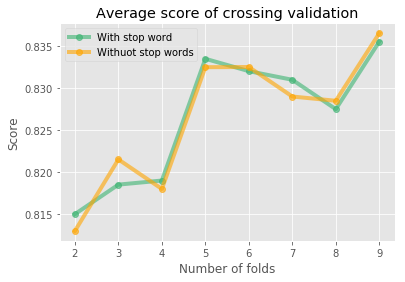

Score with stop words :  0.822
Score without stop words :  0.841


In [11]:
# Plot all# Plot a 
plt.plot(np.arange(2,10), scores, linewidth=4, alpha=0.6, 
         marker='o', color="mediumseagreen", label='With stop word')

plt.plot(np.arange(2,10), no_sw_scores, linewidth=4, alpha=0.6, 
         marker='o', color="orange", label='Withuot stop words')
plt.title("Average score of crossing validation")
plt.ylabel('Score')
plt.xlabel('Number of folds')
plt.legend()
plt.show()


print("Score with stop words : ", score)
print("Score without stop words : ", score_no_stop_word)

Accroding to the score, we find when we remove the stop-words in the texts, we can improve the performence of the estimator. But when we change the number of folds. The performences are not always improved when we remove the stop word. It's means that the stop words don't always have a significant influence on the results of classification.

# SCIKIT-LEARN USE

## Question 1:
Compare your implementation with scikitlearn

In [12]:
nb_pipline = Pipeline([('count', CountVectorizer()), ('nb', MultinomialNB())])

nb_res = cross_validate(nb_pipline.set_params(
    count__analyzer='word'), texts, y, cv=5)

nb_bigram_res = cross_validate(nb_pipline.set_params(
    count__analyzer='word', count__ngram_range=(2, 2)), texts, y, cv=5)

nb_char_res = cross_validate(nb_pipline.set_params(
    count__analyzer='char', count__ngram_range=(1, 1), count__stop_words=None), texts, y, cv=5)


nb_res_stop_word = cross_validate(nb_pipline.set_params(
    count__analyzer='word', count__ngram_range=(3,6), count__stop_words='english'), texts, y, cv=5)

nb_bigram_res_stop_word = cross_validate(nb_pipline.set_params(
    count__analyzer='word', count__ngram_range=(2, 2), count__stop_words='english'), texts, y, cv=5)


nb_char_res_stop_word = cross_validate(nb_pipline.set_params(
    count__analyzer='char', count__ngram_range=(3, 6), count__stop_words='english'), texts, y, cv=5)

In [13]:
nb_score = np.mean(nb_res['test_score'])

[]

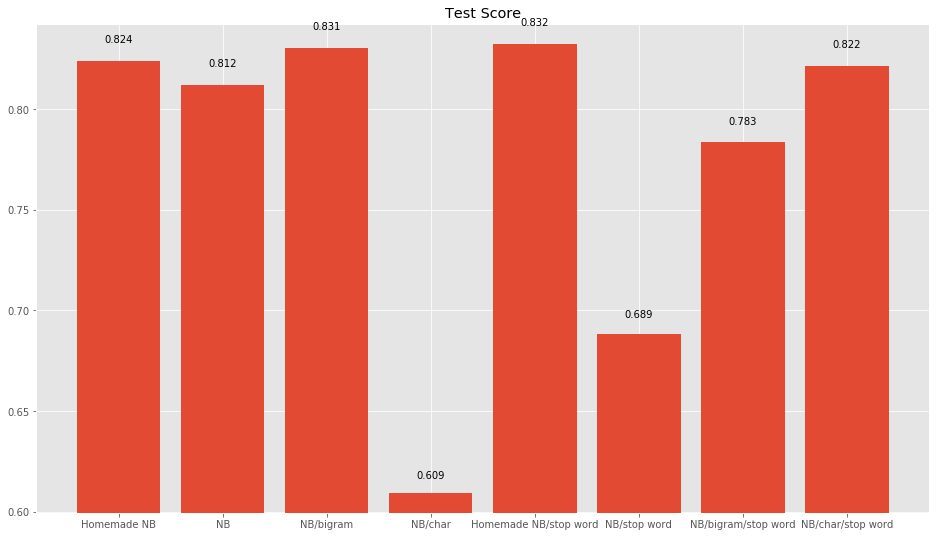

In [14]:
label = ['Homemade NB', 'NB','NB/bigram', 'NB/char'  
         ,'Homemade NB/stop word'
         , 'NB/stop word' , 'NB/bigram/stop word'
        , 'NB/char/stop word']
data = [my_nb_res
           ,nb_res
           ,nb_bigram_res
           ,nb_char_res
           , my_nb_res_stop_word
           ,nb_res_stop_word 
           ,nb_bigram_res_stop_word
          ,nb_char_res_stop_word]

fig,ax = plt.subplots(figsize=(16,9))

x = [np.mean(res['test_score']) for res in data]
rect = ax.bar(range(len(label)),x, tick_label =label)
plt.ylim(min(x) -0.01, max(x) + 0.01)
plt.title("Test Score")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rect)

plt.plot()

According to the results above, we can find that the the performence of homemade implementation is enough good. 
This the bigram not work well for our samples.
With the bigram, we can improve the performence. And we also find that removing the stop word can not always improve the performences.

Influcenc about 
When we work on substrings of characters, we get the lowest scores.

## Question 2
Test another classification method scikitlearn (ex : LinearSVC, LogisticRegression).



### Setup

In [15]:
def test_score(estimator, texts = texts):
    lable = ["Word", "Bigram", "Char"
         ,"Word/Stop Word", "Bigram/Stop Word", "Char/Stop Word"]
    res = cross_validate(estimator, texts, y, cv=5)

    bigram_res = cross_validate(estimator.set_params(
        count__analyzer='word', count__ngram_range=(2, 2), count__stop_words=None), texts, y, cv=5)

    char_res = cross_validate(estimator.set_params(
        count__analyzer='char', count__ngram_range=(1, 1), count__stop_words=None), texts, y, cv=5)

    res_stop_word = cross_validate(estimator.set_params(
        count__analyzer='word', count__ngram_range=(3,6), count__stop_words='english'), texts, y, cv=5)

    bigram_res_stop_word = cross_validate(estimator.set_params(
        count__analyzer='word', count__ngram_range=(2, 2), count__stop_words='english'), texts, y, cv=5)

    char_res_stop_word = cross_validate(estimator.set_params(
        count__analyzer='char', count__ngram_range=(3, 6), count__stop_words='english'), texts, y, cv=5)
    
    return label, [res, bigram_res,char_res, res_stop_word, bigram_res_stop_word,char_res_stop_word]

### Linear SVC

In [16]:
%%time
svc_pipline = Pipeline([('count', CountVectorizer()), ('svc', LinearSVC())])
label_svc, data_svc = test_score(svc_pipline)
svc_score = np.mean(data_svc[0]['test_score'])

Wall time: 14min 31s


### Logistic regression

In [17]:
%%time
lr_pipline = Pipeline([('count', CountVectorizer()),
                       ('lr', LogisticRegression())])
label_lr, data_lr = test_score(lr_pipline)
lr_score = np.mean(data_svc[0]['test_score'])

Wall time: 11h 32min 1s


### Comparaison

[0.812, 0.8305000000000001, 0.6094999999999999, 0.6885, 0.7835, 0.8215]


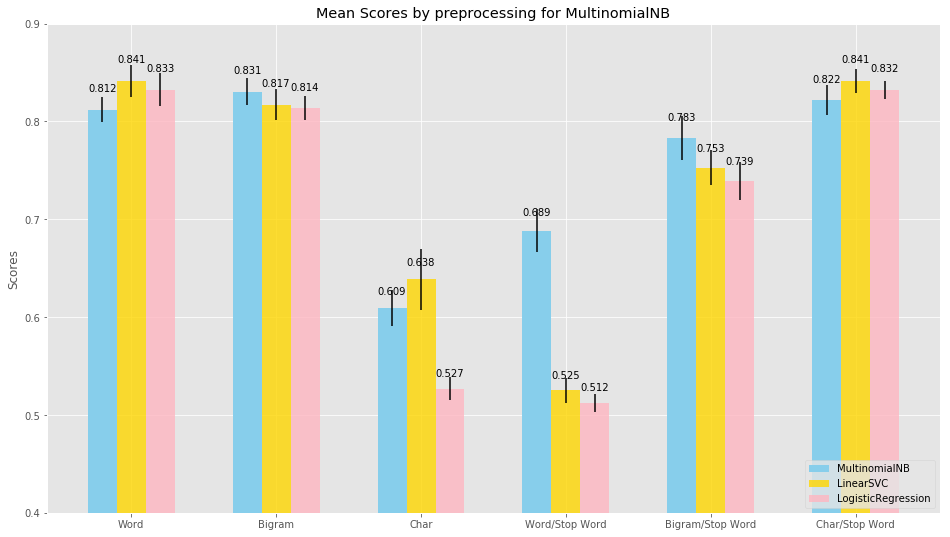

In [18]:
label = ["Word", "Bigram", "Char"
         ,"Word/Stop Word", "Bigram/Stop Word", "Char/Stop Word"]
data_nb = [nb_res
           ,nb_bigram_res
           ,nb_char_res
           ,nb_res_stop_word 
           ,nb_bigram_res_stop_word
          ,nb_char_res_stop_word]


fig, ax = plt.subplots(figsize=(16,9))
width = 0.2
alp = 0.8
ind = np.arange(6)
print([np.mean(l['test_score']) for l in data_nb])
    
rects1 = ax.bar(ind, [np.mean(l['test_score']) for l in data_nb], 
                width = width,label='MultinomialNB', color='skyblue' ,
                yerr=[np.std(l['test_score']) for l in data_nb]
               )

rects2 = ax.bar(ind + width, [np.mean(l['test_score']) for l in data_lr], 
                width, alpha=alp, label='LinearSVC', color='gold'
   ,yerr=[np.std(l['test_score']) for l in data_svc])
#              
rects3 = ax.bar(ind + 2 * width, [np.mean(l['test_score']) for l in data_svc], 
                width, alpha=alp, label='LogisticRegression', color='lightpink' 
                , yerr=[np.std(l['test_score']) for l in data_lr]
                )

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Mean Scores by preprocessing for MultinomialNB')
ax.set_xticks(ind + 2 * width / 2)
ax.set_xticklabels(label)
ax.set_ylim(0.4,0.9)
plt.legend(loc="lower right")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()


With this figure, the performence of SVC is best when we work on word and keep the stop word. When we rmove the stop word from our texts, the performence about word and bigram decline for the three algorithms. 
When we segement the texts by character, the performence is so bad, but when we remove the stop word, the perfomence significantly enhance, the score even is higher than the segmentation by word. 
In ours sample, the bigram don't bring benefit for our clasification.

## Question 3 NLTK
Use NLTK library in order to process a stemming. You will used the class
SnowballStemmer.

In [19]:
from nltk import SnowballStemmer

stemmer = SnowballStemmer("english")
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])       

In [20]:
%%time
## MultinamialNB with stem
nb_stem_pipline = Pipeline([('count', StemmedCountVectorizer()),
                      ('mnb', MultinomialNB())])
nb_stem_score = np.mean(cross_val_score(nb_stem_pipline, texts, y, cv=5))

Wall time: 1min 35s


In [21]:
%%time
## SVC with stem
svc_stem_pipline = Pipeline([('count', StemmedCountVectorizer()),
                      ('svc', LinearSVC())])
svc_stem_score = np.mean(cross_val_score(svc_stem_pipline, texts, y, cv=5))

Wall time: 1min 39s


In [22]:
%%time
## LogisticRegression with sem
lr_stem_pipline = Pipeline([('count', StemmedCountVectorizer()),
                      ('lr', LogisticRegression())])
lr_stem_score = np.mean(cross_val_score(lr_stem_pipline, texts, y, cv=5))  

Wall time: 1min 36s


We will discribe the results in next part.

## Question 4
Filter words by grammatical category (POS : Part Of Speech) and keep only nouns,
verbs, adverbs and adjectives for classification.

In [23]:
from nltk import pos_tag
from nltk import word_tokenize

def filter_pos(texts=texts):
    filtered = [list(filter(lambda x: (x[1] == 'NOUN') 
                         or (x[1] == 'VERB') 
                         or (x[1] == 'ADV') 
                         or (x[1] == 'ADJ'), pos_tag(word_tokenize(txt), tagset='universal'))) for txt in texts]
    return filtered

def apply_pos_tag(filtered):
    postagged = []
    for i, tuples in enumerate(filtered, 0):
        postagged.append('')
        for t in tuples:
            postagged[i] += t[0] + ' '
    return postagged

In [24]:
postText = apply_pos_tag(filter_pos())

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  Searched in:
    - 'C:\\Users\\zhufa/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'D:\\ProgramData\\Anaconda3\\nltk_data'
    - 'D:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\zhufa\\AppData\\Roaming\\nltk_data'
    - ''
**********************************************************************


In [ ]:
%%time
## MultinomialNB
nb_pipline = Pipeline([('count', CountVectorizer()), ('svc', MultinomialNB())])
nb_pos_tag_score = np.mean(cross_val_score(nb_pipline, postText, y))

In [ ]:
%%time
## SVC
svc_pipline = Pipeline([('count', CountVectorizer()),
                      ('svc', LinearSVC())])
svc_pos_tag_score = np.mean(cross_val_score(svc_pipline, postText, y))

In [ ]:
%%time
## LogisticRegression
lr_pipline = Pipeline([('count', CountVectorizer()),
                      ('lr', LogisticRegression())])
lr_pos_tag_score = np.mean(cross_val_score(lr_pipline, postText, y))  

In [ ]:
nb_res_score = [nb_score, ]
label = ['MultinomialNB', 'LinearSVC', 'LogisticRegression']
ori_scores = [nb_score, svc_score, lr_score]
stem_scores = [nb_stem_score, svc_stem_score, lr_stem_score]
pos_tag_scores = [nb_pos_tag_score, svc_pos_tag_score, lr_pos_tag_score]

In [ ]:
label = ["MultinomialNB", "LinearSVC", "LogisticRegression"]

fig, ax = plt.subplots(figsize=(16,9))
width = 0.2
alp = 0.8
ind = np.arange(3)
    
rects1 = ax.bar(ind, ori_scores, 
                width = width,label='Model', color='skyblue')

rects2 = ax.bar(ind + width, stem_scores, 
                width, alpha=alp, label='Model + stem', color='gold')
#              
rects3 = ax.bar(ind + 2 * width, pos_tag_scores, 
                width, alpha=alp, label='Model + pos_tag', color='lightpink')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Mean Scores by preprocessing for MultinomialNB')
ax.set_xticks(ind + 2 * width / 2)
ax.set_xticklabels(label)
ax.set_ylim(0.4,0.9)
plt.legend(loc="lower right")
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

With this figure, we can find, the Stem and pos-tag don't have a significant influence on the classification of document with our samples.